# Libraries

In [66]:
import pandas as pd
import numpy as np

# RWA_IRB

## New rules

In [67]:
#PD retail input floor: 5bp or 0.05%
#LGD unsecured retail exposures: 30%
#1.06 scaling factor removed

#Retail: no maturity adjustment (M)
#Asset correlation R and capital requirement K formulated

## IRB Function

In [68]:

from scipy.stats import norm


def calculate_basel_iv_rwa(df):
    """
    Calculates RWA for Unsecured Retail Loans under Basel IV (Finalised Basel III).

    Parameters:
    df (pd.DataFrame): DataFrame containing 'PD', 'LGD', 'EAD'.
                       PD and LGD should be in decimal format (e.g., 0.02 for 2%).

    Returns:
    pd.DataFrame: The input DataFrame with added 'RWA' and 'Capital_Requirement' columns.
    """

    # --- 1. Apply Basel IV Input Floors ---
    # PD Floor: 0.05% (0.0005)
    # LGD Floor: 30% (0.30) for Unsecured Retail

    df['PD_Floored'] = np.maximum(df['PD'], 0.0005)
    df['LGD_Floored'] = np.maximum(df['LGD'], 0.30)

    # Note: Ensure PD is not exactly 1 (Defaulted), as it breaks the Inverse Normal.
    # For defaulted assets (PD=1), RWA is usually calculated differently (e.g., Max(0, LGD-ELBE) * 12.5).
    # Here we cap PD at 0.999 for the formula, but separate logic applies to actual defaults.
    df['PD_Final'] = np.minimum(df['PD_Floored'], 0.999)

    # --- 2. Calculate Correlation (R) for "Other Retail" ---
    # Formula: R varies between 0.03 and 0.16 based on PD
    # The constant (1 - exp(-35)) is approx 1, but we include it for exactness.

    c_factor = (1 - np.exp(-35 * df['PD_Final'])) / (1 - np.exp(-35))
    df['Correlation'] = 0.03 * c_factor + 0.16 * (1 - c_factor)

    # --- 3. Calculate Capital Requirement (K) ---
    # Term 1: Inverse Normal of PD
    inv_n_pd = norm.ppf(df['PD_Final'])

    # Term 2: Inverse Normal of 99.9% confidence interval
    inv_n_999 = norm.ppf(0.999)

    # Term 3: The detailed numerator and denominator inside the N() function
    numerator = inv_n_pd + np.sqrt(df['Correlation']) * inv_n_999
    denominator = np.sqrt(1 - df['Correlation'])

    # Term 4: N(Term 3)
    cumulative_term = norm.cdf(numerator / denominator)

    # K Formula: LGD * N(...) - LGD * PD
    df['K'] = (df['LGD_Floored'] * cumulative_term) - (df['LGD_Floored'] * df['PD_Final'])

    # Ensure K is not negative (mathematically unlikely but safe to floor at 0)
    df['K'] = np.maximum(df['K'], 0)

    # --- 4. Calculate RWA ---
    # The 1.06 scaling factor is REMOVED in Basel IV
    df['RWA'] = df['K'] * 12.5 * df['EAD']

    return df


# --- Example Usage ---

# Sample Data (PD and LGD in decimals)
data = {
    'Loan_ID': [101, 102, 103],
    'PD': [0.02, 0.0003, 0.15],  # Note: 0.0003 is below floor
    'LGD': [0.45, 0.25, 0.55],  # Note: 0.25 is below floor
    'EAD': [10000, 50000, 15000]
}

df_loans = pd.DataFrame(data)

# Calculate
df_result = calculate_basel_iv_rwa(df_loans)

# Output results
print(df_result[['Loan_ID', 'PD', 'PD_Floored', 'LGD_Floored', 'Correlation', 'RWA']])
print(f"\nTotal Portfolio RWA: {df_result['RWA'].sum():,.2f}")

   Loan_ID      PD  PD_Floored  LGD_Floored  Correlation           RWA
0      101  0.0200      0.0200         0.45     0.094556   5798.644298
1      102  0.0003      0.0005         0.30     0.157745   2209.706421
2      103  0.1500      0.1500         0.55     0.030682  16243.481712

Total Portfolio RWA: 24,251.83


## Data

In [69]:
df = pd.read_csv('loan_data_EL.csv')

/var/folders/70/w17hvdpd0hl783xb5m_jdw3m0000gn/T/ipykernel_73171/2368006233.py:1: DtypeWarning: Columns (21,57,271,290,335,371,585,604) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan_data_EL.csv')


In [70]:
df_irb = calculate_basel_iv_rwa(df)

In [71]:
df[['id','funded_amnt','PD','LGD','EAD','EL','PD_Floored','PD_Final','Correlation','K','RWA']]

,id,funded_amnt,PD,LGD,EAD,EL,PD_Floored,PD_Final,Correlation,K,RWA
0,58544248,35000,0.006990,1.0,33472.851677,233.991028,0.006990,0.006990,0.131786,0.068833,28800.533816
1,60277044,18000,0.012593,1.0,18000.000000,226.676381,0.012593,0.012593,0.113661,0.089250,20081.220017
2,63569148,30000,0.011125,1.0,27039.997465,300.824016,0.011125,0.011125,0.118072,0.085062,28750.822890
3,62336456,2000,0.019345,1.0,1828.968956,35.381130,0.019345,0.019345,0.096053,0.102219,2336.946487
4,61318661,12000,0.020847,1.0,11515.778451,240.064340,0.020847,0.020847,0.092671,0.104134,14989.764553
...,...,...,...,...,...,...,...,...,...,...,...
421089,60875062,20000,0.008350,1.0,18390.428203,153.560214,0.008350,0.008350,0.127056,0.075051,17252.835398
421090,63396201,13000,0.027542,1.0,12469.333057,343.431518,0.027542,0.027542,0.079579,0.110146,17168.030377
421091,60687243,8000,0.003445,1.0,7813.392563,26.915171,0.003445,0.003445,0.145234,0.046140,4506.345048
421092,59111572,16000,0.004776,1.0,15599.170920,74.496337,0.004776,0.004776,0.139990,0.056051,10929.322120


In [72]:
df_irb['PD'].mean()

np.float64(0.01869433342409512)

In [73]:
df_irb['PD_Floored'].mean()

np.float64(0.01869433342409512)

# RWA_SA

In [74]:
#PerformingExposure <= €1m (Standard)75%
#PerformingExposure > €1m (High Value)100%
#DefaultedProvisions >= 20% of Loan100%
#DefaultedProvisions < 20% of Loan150%

In [75]:

def calculate_basel_iv_sa_rwa(df, provision_proxy_col='EL'):
    """
    Calculates Basel IV Standardised Approach RWA

    Parameters:
    df (pd.DataFrame): The dataframe containing the loan data.
    provision_proxy_col (str): Column to use as a proxy for Specific Provisions (default 'EL').
                               If actual provisions are 0, Risk Weight for defaults will be 150%.
    """
    df = df.copy()

    # --- 1. MAPPING COLUMNS ---
    # Map the dataset's specific column names to standard variables

    # Customer Identifier: Use 'member_id' to group exposures
    col_customer = 'member_id'

    # Exposure: Use 'EAD'
    col_ead = 'EAD'

    # Default Indicator:
    # construct a single flag from the one-hot encoded status columns and PD.
    # Basel Definition: >90 days past due or unlikely to pay.
    # check if any of the bad statuses are 1 (True).

    # List of columns that indicate default
    default_cols = [
        'loan_status:Default',
        'loan_status:Charged Off',
        # Note: 'Late (31-120 days)' is ambiguous (could be <90),
        # so we often rely on PD=1 for the confirmed defaults if available.
    ]

    # Ensure these columns exist before summing (handle missing columns gracefully)
    existing_def_cols = [c for c in default_cols if c in df.columns]

    if existing_def_cols:
        # If any of these are 1, it's a default
        df['is_default_status'] = df[existing_def_cols].max(axis=1)
    else:
        df['is_default_status'] = 0

    # Combine with PD check (if PD is effectively 100%, it's a default)
    # Using 0.99 as a safe threshold for floating point numbers
    df['Default_Flag'] = np.where((df['is_default_status'] == 1) | (df['PD'] > 0.99), 1, 0)

    # Provisions:
    # Standardised Approach compares Provisions to EAD to decide 100% vs 150% RW for defaults.
    # Since 'Specific_Provisions' isn't in your list, we use 'EL' (Expected Loss) or 0.
    if provision_proxy_col in df.columns:
        df['Provisions_Value'] = df[provision_proxy_col]
    else:
        df['Provisions_Value'] = 0 # Conservative assumption

    # --- 2. CALCULATE AGGREGATE EXPOSURE (For €1m Limit) ---
    # Basel IV Rule: If total retail exposure to one person > €1m, RW is 100% (not 75%).

    # Sum EAD by Customer
    cust_agg = df.groupby(col_customer)[col_ead].sum().reset_index()
    cust_agg.rename(columns={col_ead: 'Total_Customer_Exposure'}, inplace=True)

    # Merge back to main dataframe
    df = df.merge(cust_agg, on=col_customer, how='left')

    # Define threshold (Assuming data is in USD/EUR parity for simplicity, or adjust limit)
    # Limit is 1 million units of currency
    RETAIL_THRESHOLD = 1_000_000

    # --- 3. ASSIGN RISK WEIGHTS (Standardised Approach) ---

    def get_sa_risk_weight(row):
        # -- CASE A: DEFAULTED EXPOSURE --
        if row['Default_Flag'] == 1:
            # Avoid division by zero
            if row[col_ead] <= 0:
                return 0.0

            # Calculate Coverage Ratio (Provisions / EAD)
            coverage = row['Provisions_Value'] / row[col_ead]

            # Rule:
            # < 20% Coverage -> 150% RW
            # >= 20% Coverage -> 100% RW
            if coverage < 0.20:
                return 1.50
            else:
                return 1.00

        # -- CASE B: PERFORMING EXPOSURE --
        else:
            # Rule:
            # Regulatory Retail (Standard) -> 75% RW
            # Other Retail (Breaches €1m limit) -> 100% RW
            if row['Total_Customer_Exposure'] > RETAIL_THRESHOLD:
                return 1.00
            else:
                return 0.75

    # Apply logic
    df['SA_Risk_Weight'] = df.apply(get_sa_risk_weight, axis=1)

    # --- 4. CALCULATE SA RWA ---
    df['SA_RWA'] = df[col_ead] * df['SA_Risk_Weight']

    return df


In [76]:
df_sa = calculate_basel_iv_sa_rwa(df, provision_proxy_col='EL')

In [77]:
df_sa['SA_Risk_Weight'].unique()

array([0.75, 1.5 , 1.  ])

In [78]:
df_sa.head()

,Unnamed: 0,Unnamed: 0.2,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,PD_Final,Correlation,K,RWA,is_default_status,Default_Flag,Provisions_Value,Total_Customer_Exposure,SA_Risk_Weight,SA_RWA
0,163466,0,58544248,62385031,35000,35000,35000.0,36 months,9.99,1129.19,...,0.006990,0.131786,0.068833,28800.533816,0,0,233.991028,33472.851677,0.75,25104.638758
1,141710,1,60277044,64253819,18000,18000,18000.0,60 months,14.65,424.92,...,0.012593,0.113661,0.089250,20081.220017,0,0,226.676381,18000.000000,0.75,13500.000000
2,75700,2,63569148,67958896,30000,30000,29750.0,36 months,11.49,989.14,...,0.011125,0.118072,0.085062,28750.822890,0,0,300.824016,27039.997465,0.75,20279.998099
3,102660,3,62336456,66533198,2000,2000,2000.0,36 months,13.99,68.35,...,0.019345,0.096053,0.102219,2336.946487,0,0,35.381130,1828.968956,0.75,1371.726717
4,107838,4,61318661,65437387,12000,12000,11975.0,60 months,16.99,298.17,...,0.020847,0.092671,0.104134,14989.764553,0,0,240.064340,11515.778451,0.75,8636.833839


In [79]:
df_sa[['id','funded_amnt','PD','LGD','EAD','EL','PD_Floored','PD_Final','Correlation','K','RWA','is_default_status','Default_Flag','Provisions_Value','Total_Customer_Exposure','SA_Risk_Weight','SA_RWA']]

,id,funded_amnt,PD,LGD,EAD,EL,PD_Floored,PD_Final,Correlation,K,RWA,is_default_status,Default_Flag,Provisions_Value,Total_Customer_Exposure,SA_Risk_Weight,SA_RWA
0,58544248,35000,0.006990,1.0,33472.851677,233.991028,0.006990,0.006990,0.131786,0.068833,28800.533816,0,0,233.991028,33472.851677,0.75,25104.638758
1,60277044,18000,0.012593,1.0,18000.000000,226.676381,0.012593,0.012593,0.113661,0.089250,20081.220017,0,0,226.676381,18000.000000,0.75,13500.000000
2,63569148,30000,0.011125,1.0,27039.997465,300.824016,0.011125,0.011125,0.118072,0.085062,28750.822890,0,0,300.824016,27039.997465,0.75,20279.998099
3,62336456,2000,0.019345,1.0,1828.968956,35.381130,0.019345,0.019345,0.096053,0.102219,2336.946487,0,0,35.381130,1828.968956,0.75,1371.726717
4,61318661,12000,0.020847,1.0,11515.778451,240.064340,0.020847,0.020847,0.092671,0.104134,14989.764553,0,0,240.064340,11515.778451,0.75,8636.833839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421089,60875062,20000,0.008350,1.0,18390.428203,153.560214,0.008350,0.008350,0.127056,0.075051,17252.835398,0,0,153.560214,18390.428203,0.75,13792.821152
421090,63396201,13000,0.027542,1.0,12469.333057,343.431518,0.027542,0.027542,0.079579,0.110146,17168.030377,0,0,343.431518,12469.333057,0.75,9351.999793
421091,60687243,8000,0.003445,1.0,7813.392563,26.915171,0.003445,0.003445,0.145234,0.046140,4506.345048,0,0,26.915171,7813.392563,0.75,5860.044423
421092,59111572,16000,0.004776,1.0,15599.170920,74.496337,0.004776,0.004776,0.139990,0.056051,10929.322120,0,0,74.496337,15599.170920,0.75,11699.378190


# Output floor

In [80]:
IRB = df_irb['RWA'].sum()

In [81]:
SA = df_sa['SA_RWA'].sum()

In [82]:
IRB

np.float64(6579345260.705986)

In [83]:
SA

np.float64(4605923660.687471)

In [84]:
IRB - SA

np.float64(1973421600.0185146)

In [85]:
(IRB - SA) /SA

np.float64(0.4284529543687586)

In [86]:
avg = df['K'].mean()
avg/0.08

np.float64(1.0779822608981042)

In [87]:
(df_irb['RWA'].sum())/(df_irb['EAD'].sum())

np.float64(1.0793084925432301)

In [88]:
df_sa['SA_Risk_Weight'].mean()

np.float64(0.7556270096463023)

In [89]:
df['LGD'].min()

np.float64(0.5797267259804778)

In [90]:
df['recoveries'].describe()

count    421094.000000
mean          2.263264
std         111.428440
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       26308.470000
Name: recoveries, dtype: float64

In [91]:
df['LGD'].describe()

count    421094.000000
mean          0.999988
std           0.001629
min           0.579727
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

In [92]:
SA * 0.725

np.float64(3339294653.9984164)

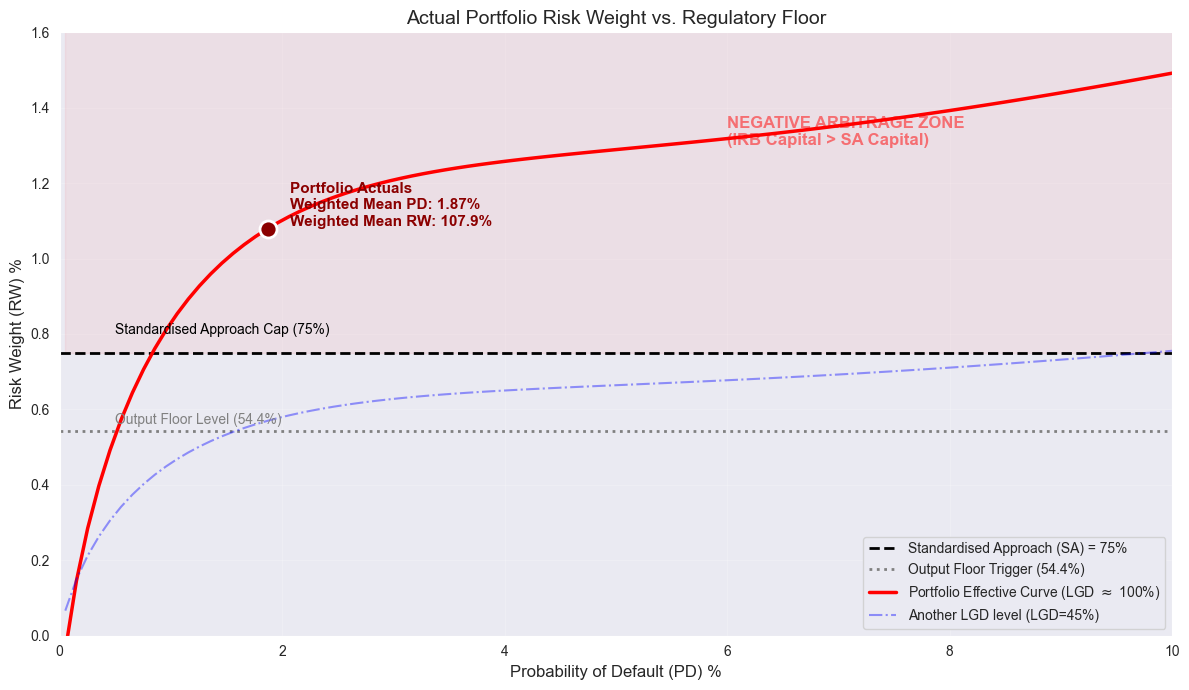

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Basel IV IRB Function ---
def calculate_irb_rw(pd, lgd):
    # Apply Basel IV Floors
    pd_final = np.maximum(pd, 0.0005)

    # Correlation (R) for Other Retail
    c_factor = (1 - np.exp(-35 * pd_final)) / (1 - np.exp(-35))
    r = 0.03 * c_factor + 0.16 * (1 - c_factor)

    # Capital K
    inv_pd = norm.ppf(pd_final)
    inv_999 = norm.ppf(0.999)
    numerator = inv_pd + np.sqrt(r) * inv_999
    denominator = np.sqrt(1 - r)

    k = (lgd * norm.cdf(numerator / denominator)) - (lgd * pd_final)
    k = np.maximum(0, k)

    return k * 12.5 # Risk Weight

def plot_rwa_analysis():
    # 1. Setup Data
    pds = np.linspace(0.0005, 0.10, 100) # Plot PD from 0.05% to 10%

    # Your exact portfolio statistics from the Notebook
    my_mean_lgd = 0.999988
    my_mean_pd = 0.01869
    my_actual_rw = 1.0793

    # 2. Calculate Curve Adjustment (The "Convexity Premium")
    # We calculate the gap between the theoretical value at mean PD and your actual weighted RW
    theoretical_rw_at_mean = calculate_irb_rw(my_mean_pd, my_mean_lgd)
    convexity_shift = my_actual_rw - theoretical_rw_at_mean

    # 3. Generate Curves
    # We apply the shift to the whole curve so it represents your portfolio structure
    rw_curve_adjusted = [calculate_irb_rw(p, my_mean_lgd) + convexity_shift for p in pds]
    rw_curve_typical = [calculate_irb_rw(p, 0.45) for p in pds]

    # 4. Plotting
    plt.figure(figsize=(12, 7))

    # SA Reference Line (75%)
    plt.axhline(y=0.75, color='black', linestyle='--', linewidth=2, label='Standardised Approach (SA) = 75%')

    # Output Floor Trigger Line (72.5% of SA)
    floor_trigger = 0.75 * 0.725
    plt.axhline(y=floor_trigger, color='grey', linestyle=':', linewidth=2, label='Output Floor Trigger (54.4%)')

    # IRB Curves
    # Plot the adjusted curve that passes through the point with LGD info
    plt.plot(pds*100, rw_curve_adjusted, color='red', linewidth=2.5, label=f'Portfolio Effective Curve (LGD $\\approx$ {my_mean_lgd*100:.0f}%)')

    # Plot the comparison curve
    plt.plot(pds*100, rw_curve_typical, color='blue', alpha=0.4, linestyle='-.', label='Another LGD level (LGD=45%)')

    # Your Actual Position Marker
    plt.scatter([my_mean_pd*100], [my_actual_rw], color='darkred', s=150, zorder=5, edgecolors='white', linewidth=2)

    # Annotations
    plt.text(my_mean_pd*100 + 0.2, my_actual_rw,
             f"Portfolio Actuals\nWeighted Mean PD: {my_mean_pd*100:.2f}%\nWeighted Mean RW: {my_actual_rw*100:.1f}%",
             verticalalignment='bottom', fontsize=11, fontweight='bold', color='darkred')

    plt.text(0.5, 0.80, "Standardised Approach Cap (75%)", color='black', fontsize=10)
    plt.text(0.5, 0.56, "Output Floor Level (54.4%)", color='grey', fontsize=10)

    # Titles and Formatting
    plt.title("Actual Portfolio Risk Weight vs. Regulatory Floor", fontsize=14)
    plt.xlabel("Probability of Default (PD) %", fontsize=12)
    plt.ylabel("Risk Weight (RW) %", fontsize=12)
    plt.ylim(0, 1.6)
    plt.xlim(0, 10)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.2)

    # Highlight Negative Arbitrage
    plt.fill_between(pds*100, 0.75, 2.0, color='red', alpha=0.05)
    plt.text(6, 1.3, "NEGATIVE ARBITRAGE ZONE\n(IRB Capital > SA Capital)", color='red', alpha=0.5, fontsize=12, fontweight='bold')

    plt.tight_layout()

    # Display graph in output
    plt.show()

plot_rwa_analysis()